# Hurricane multiverse (non-neuroimaging)

The Comet toolbox is developed primarily for fMRI brain network analyses. However, we here showcases how the versatile multiverse workflow can also be applied outside of neuroimaging.

This script is a re-implementation og the famous *“Female hurricanes are deadlier than male hurricanes”* multiverse analysis originally presented in [Simonsohn et al. (2020)](https://www.nature.com/articles/s41562-020-0912-z). Their study revisited [Jung et al. (2014)](https://www.pnas.org/doi/full/10.1073/pnas.1402786111), who reported that hurricanes with more feminine names caused more fatalities. Simonsohn and colleagues systematically explored how robust this conclusion is across a large range of reasonable analytic specifications.

The Comet toolbox provides a Python-native multiverse framework that allows the entire hurricane multiverse analysis to be expressed with two simple objects:

- A dictionary of forking paths
- A single analysis template function containing placeholders for all decisions

Existing examples (R implementations) of this example can be found here:

- multiverse package: https://cran.r-project.org/web/packages/multiverse/vignettes/example-hurricane.html
- mverse package: https://mverseanalysis.github.io/mverse/index.html

In [1]:
from comet.multiverse import Multiverse

forking_paths = {
    "death_outliers":  [2, 1, 0],    # Drop n hurricanes with the most deaths
    "damage_outliers": [3, 2, 1, 0], # Drop n hurricanes with the most damage

    "femininity_rating": ["fem_likert", "fem_binary"], # Femininity rating (11-point likert or binary)
    "damage_functional": ["ln", "linear"],             # Damage functional (ln or no transformation)

    "effect_type":  ["femininity * damages",
                     "femininity * damages + femininity * zpressure",
                     "femininity * damages + femininity * zwind",
                     "femininity * damages + femininity * zcat",
                     "femininity * damages + femininity * z3",
                     "femininity + damages + z3"],                       # Interactions or main effect only)
    "year_interaction":  ["", " + post1979:damages", " + year:damages"], # Interactions with year
    "model":             ["log_linear", "neg_binomial"]                  # Model (negative binomial or log-linear)
}

def analysis_template():
    import comet
    import numpy as np
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    # Load hurricane data
    df = comet.utils.load_example("hurricane")

    # Create derived predictors
    df["post1979"] = (df["elapsed_years"] > 1979).astype(int)
    df["zcat"] = (df["category"] - df["category"].mean()) / df["category"].std()
    df["zpressure"] = -((df["pressure"] - df["pressure"].mean()) / df["pressure"].std())
    df["zwind"] = (df["wind"] - df["wind"].mean()) / df["wind"].std()
    df["z3"] = (df["zpressure"] + df["zcat"] + df["zwind"]) / 3.0

    # Decisions 1 & 2: Exclude outliers
    top_deaths = df["deaths"].nlargest({{death_outliers}}).unique()
    top_damage = df["damages"].nlargest({{damage_outliers}}).unique()
    df = df[~df["deaths"].isin(top_deaths) & ~df["damages"].isin(top_damage)]

    # Decision 2: Choose femininity rating
    df["femininity"] = df[{{femininity_rating}}]

    # Decision 3: Transform damage variable
    if {{damage_functional}} == "ln":
        df["damages"] = np.log(df["damages"])

    # Decision 4 & 5: Effect type & account for year
    formula = "deaths ~ " + {{effect_type}} + {{year_interaction}}

    # Decision 6: Model type and fitting
    if {{model}} == "log_linear":
        df["deaths"] = np.log(df["deaths"] + 1)
        fit = smf.ols(formula, data=df).fit()
    else:
        fit = smf.glm(formula, data=df, family=sm.families.NegativeBinomial(alpha=1)).fit()

    # Result: Set femininity for male vs female and predict deaths at the sample means
    if {{femininity_rating}} == "fem_likert":
        fem_male = df["femininity"][df["fem_binary"] == 0].mean()
        fem_fem = df["femininity"][df["fem_binary"] == 1].mean()
    else:
        fem_male = 0
        fem_fem = 1

    base = df.mean(numeric_only=True).to_frame().T

    base_male = base.copy()
    base_male["femininity"] = fem_male

    base_fem = base.copy()
    base_fem["femininity"] = fem_fem

    if {{model}} == "log_linear":
        # Predict and back-transform (slightly simplified)
        pred_m = np.exp(fit.predict(base_male)) - 1
        pred_f = np.exp(fit.predict(base_fem)) - 1
    else:
        pred_m = fit.predict(base_male)
        pred_f = fit.predict(base_fem)

    extra_deaths = pred_f.values - pred_m.values
    comet.utils.save_universe_results({"extra_deaths": extra_deaths})

In [2]:
mverse = Multiverse(name="example_mv_hurricane")
mverse.create(analysis_template, forking_paths)
mverse.summary()

,Universe,Decision 1,Value 1,Decision 2,Value 2,Decision 3,Value 3,Decision 4,Value 4,Decision 5,Value 5,Decision 6,Value 6,Decision 7,Value 7
0,Universe_1,death_outliers,2,damage_outliers,3,femininity_rating,fem_likert,damage_functional,ln,effect_type,femininity * damages,year_interaction,NaN,model,log_linear
1,Universe_2,death_outliers,2,damage_outliers,3,femininity_rating,fem_likert,damage_functional,ln,effect_type,femininity * damages,year_interaction,NaN,model,neg_binomial
2,Universe_3,death_outliers,2,damage_outliers,3,femininity_rating,fem_likert,damage_functional,ln,effect_type,femininity * damages,year_interaction,+ post1979:damages,model,log_linear
3,Universe_4,death_outliers,2,damage_outliers,3,femininity_rating,fem_likert,damage_functional,ln,effect_type,femininity * damages,year_interaction,+ post1979:damages,model,neg_binomial
4,Universe_5,death_outliers,2,damage_outliers,3,femininity_rating,fem_likert,damage_functional,ln,effect_type,femininity * damages,year_interaction,+ year:damages,model,log_linear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,Universe_1724,death_outliers,0,damage_outliers,0,femininity_rating,fem_binary,damage_functional,linear,effect_type,femininity + damages + z3,year_interaction,NaN,model,neg_binomial
1724,Universe_1725,death_outliers,0,damage_outliers,0,femininity_rating,fem_binary,damage_functional,linear,effect_type,femininity + damages + z3,year_interaction,+ post1979:damages,model,log_linear
1725,Universe_1726,death_outliers,0,damage_outliers,0,femininity_rating,fem_binary,damage_functional,linear,effect_type,femininity + damages + z3,year_interaction,+ post1979:damages,model,neg_binomial
1726,Universe_1727,death_outliers,0,damage_outliers,0,femininity_rating,fem_binary,damage_functional,linear,effect_type,femininity + damages + z3,year_interaction,+ year:damages,model,log_linear


In [ ]:
mverse.run(parallel=8)

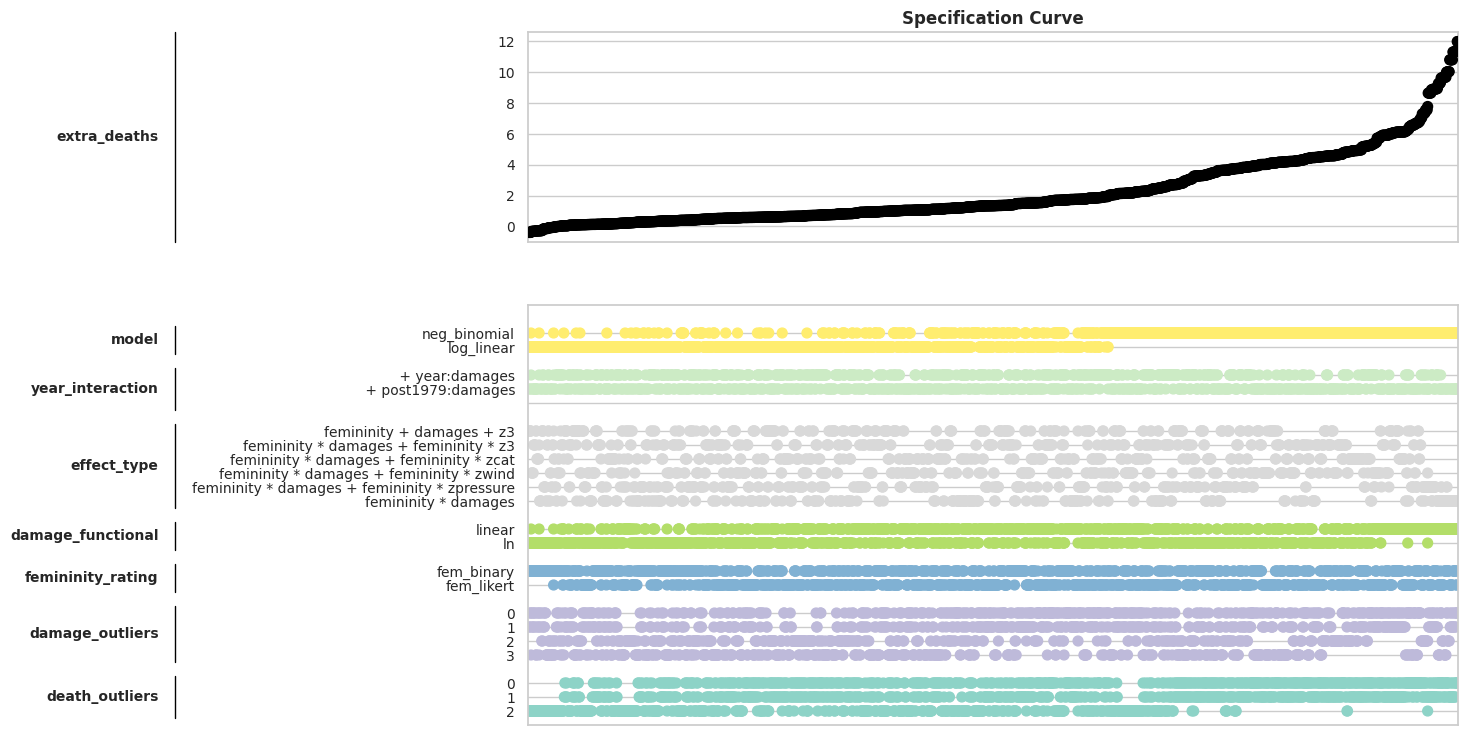

In [ ]:
mverse.specification_curve("extra_deaths", figsize=(12,9), height_ratio=(1,2), line_pad=0.05)